# **Implementation of NMIFS**

In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from ucimlrepo import fetch_ucirepo

def entropy(X):
    """Calculates the entropy of a feature"""
    _, counts = np.unique(X, return_counts=True)
    probabilities = counts / len(X)
    return -np.sum(probabilities * np.log2(probabilities + 1e-10))

def normalized_mutual_info(X, Y):
    """Calculates the normalized mutual information between X and Y"""
    mi = mutual_info_classif(X.reshape(-1, 1), Y, discrete_features=True)[0]
    return mi / min(entropy(X), entropy(Y))

def nmifs(X, y, k):
    """
    Feature selection with normalized mutual information
    
    X: feature matrix (n_samples, n_features)
    y: target variable
    k: number of features to select
    """
    n_features = X.shape[1]
    F = list(range(n_features))  # Initial set of features
    S = []  # Selected features
    
    # Compute MI with respect to the classes
    mi_y = [normalized_mutual_info(X[:, i], y) for i in range(n_features)]
    
    # Select the first feature
    best_feature = np.argmax(mi_y)
    S.append(best_feature)
    F.remove(best_feature)
    print(f'First feature selected: {best_feature}')
    
    # Greedy selection
    while len(S) < k:
        mi_scores = []
        for i in F:
            # Calculate the average normalized MI between the candidate feature and the selected features
            avg_mi = np.mean([normalized_mutual_info(X[:, i], X[:, j]) for j in S])
            
            # Calculate the selection criterion
            score = mi_y[i] - avg_mi
            mi_scores.append(score)
        
        # Select the feature that maximizes the score
        best_feature = F[np.argmax(mi_scores)]
        S.append(best_feature)
        F.remove(best_feature)
        print(f'New feature selected: {best_feature}')
    
    return S

# Load the data
darwin = fetch_ucirepo(id=732) 
X = darwin.data.features 
y = darwin.data.targets 

# Remove unnecessary columns
X = X.drop(columns=['ID'])

# Ensure y is a 1D array
y = np.ravel(y)  # Ensures that y is 1D

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Encode the target labels as integers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

'''
# Discretize continuous features using only the training set
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample=200000)
X_train_discretized = discretizer.fit_transform(X_train)
X_test_discretized = discretizer.transform(X_test)  # Apply the same transformation to the test set
'''

# Select features using NMIFS on the training set
k = 5  # Number of features to select
selected_features = nmifs(X_train_discretized, y_train_encoded, k)
print(f'Selected features: {selected_features}')

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_features].tolist()
print(f'Names of selected features: {selected_feature_names}')

# Apply the feature selection to the test set
X_train_selected = X_train_discretized[:, selected_features]
X_test_selected = X_test_discretized[:, selected_features]

# Now you can use X_train_selected and X_test_selected for model training and evaluation

First feature selected: 337
New feature selected: 116
New feature selected: 294
New feature selected: 53
New feature selected: 379
Selected features: [337, 116, 294, 53, 379]
Names of selected features: ['num_of_pendown19', 'mean_gmrt7', 'mean_acc_in_air17', 'total_time3', 'disp_index22']


## Pipeline

The following code implements a machine learning pipeline that combines Normalized Mutual Information Feature Selection (NMIFS) with a Random Forest classifier to analyze the Darwin dataset. It explores the impact of selecting different numbers of features (from 2 to 10) on model performance. The pipeline uses 5-fold cross-validation to evaluate multiple metrics (accuracy, precision, recall, and F1 score) for each feature set size. The results are then visualized to help determine the optimal number of features for maximizing the Random Forest classifier's performance. This approach allows for a systematic comparison of how feature selection affects the model's predictive capabilities across various performance metrics.

    k  accuracy  precision    recall        f1
0   2  0.654622   0.664068  0.654622  0.643160
1   3  0.648571   0.658641  0.648571  0.642716
2   4  0.653950   0.668904  0.653950  0.647673
3   5  0.676975   0.693017  0.676975  0.669585
4   6  0.705882   0.722289  0.705882  0.701537
5   7  0.722857   0.734925  0.722857  0.720188
6   8  0.740168   0.762580  0.740168  0.736329
7   9  0.717311   0.733439  0.717311  0.714283
8  10  0.757647   0.777609  0.757647  0.754289


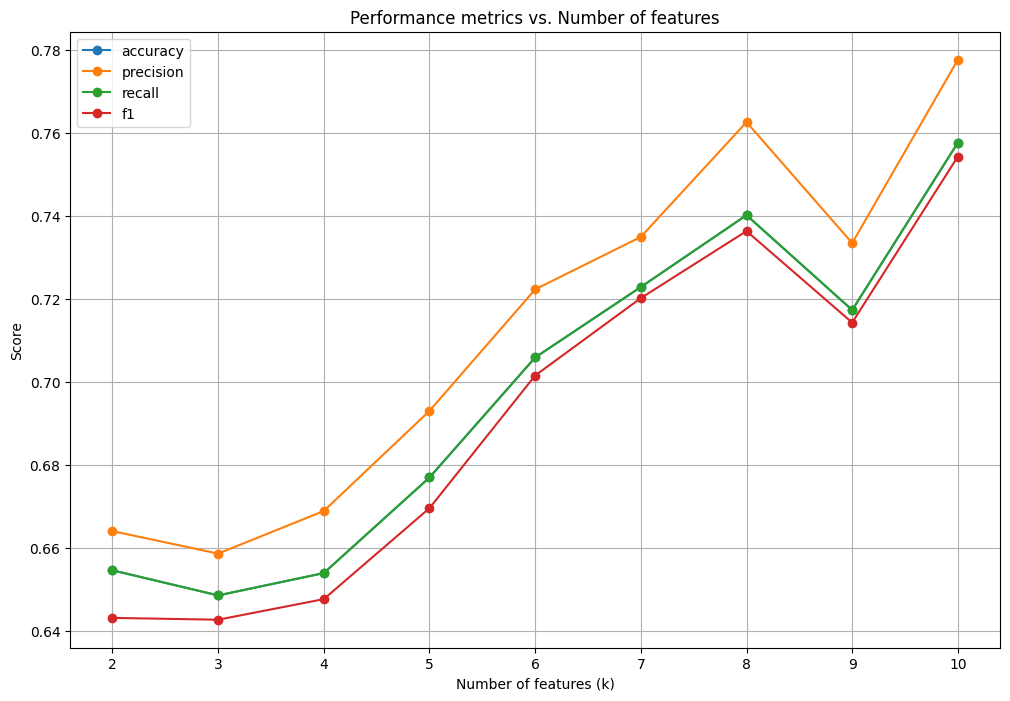

In [39]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Your existing NMIFS functions here (entropy, normalized_mutual_info, nmifs)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from ucimlrepo import fetch_ucirepo

def entropy(X):
    """Calculates the entropy of a feature"""
    _, counts = np.unique(X, return_counts=True)
    probabilities = counts / len(X)
    return -np.sum(probabilities * np.log2(probabilities + 1e-10))

def normalized_mutual_info(X, Y):
    """Calculates the normalized mutual information between X and Y"""
    mi = mutual_info_classif(X.reshape(-1, 1), Y, discrete_features=True)[0]
    return mi / min(entropy(X), entropy(Y))

def nmifs(X, y, k):
    """
    Feature selection with normalized mutual information
    
    X: feature matrix (n_samples, n_features)
    y: target variable
    k: number of features to select
    """
    n_features = X.shape[1]
    F = list(range(n_features))  # Initial set of features
    S = []  # Selected features
    
    # Compute MI with respect to the classes
    mi_y = [normalized_mutual_info(X[:, i], y) for i in range(n_features)]
    
    # Select the first feature
    best_feature = np.argmax(mi_y)
    S.append(best_feature)
    F.remove(best_feature)
    print(f'First feature selected: {best_feature}')
    
    # Greedy selection
    while len(S) < k:
        mi_scores = []
        for i in F:
            # Calculate the average normalized MI between the candidate feature and the selected features
            avg_mi = np.mean([normalized_mutual_info(X[:, i], X[:, j]) for j in S])
            
            # Calculate the selection criterion
            score = mi_y[i] - avg_mi
            mi_scores.append(score)
        
        # Select the feature that maximizes the score
        best_feature = F[np.argmax(mi_scores)]
        S.append(best_feature)
        F.remove(best_feature)
        print(f'New feature selected: {best_feature}')
    
    return S

class NMIFSSelector(BaseEstimator, TransformerMixin):
    def __init__(self, k):
        self.k = k
        
    def fit(self, X, y):
        self.selected_features_ = nmifs(X, y, self.k)
        return self
    
    def transform(self, X):
        return X[:, self.selected_features_]

# Load and preprocess the data
darwin = fetch_ucirepo(id=732) 
X = darwin.data.features 
y = darwin.data.targets 
X = X.drop(columns=['ID'])
y = np.ravel(y)

# Encode the target labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

'''
# Discretize continuous features
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample=200000)
X_discretized = discretizer.fit_transform(X)
'''

# Define the Random Forest parameters
rf_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'random_state': 42
}

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
}

# Perform cross-validation for different k values
k_values = range(2, 11)
results = []

for k in k_values:
    pipeline = Pipeline([
        ('nmifs', NMIFSSelector(k)),
        ('rf', RandomForestClassifier(**rf_params))
    ])

    scores = cross_validate(pipeline, X_discretized, y_encoded, cv=5, scoring=scoring, n_jobs=-1)

    results.append({
        'k': k,
        'accuracy': scores['test_accuracy'].mean(),
        'precision': scores['test_precision'].mean(),
        'recall': scores['test_recall'].mean(),
        'f1': scores['test_f1'].mean()
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print results
print(results_df)

# Visualize results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    plt.plot(results_df['k'], results_df[metric], marker='o', label=metric)

plt.xlabel('Number of features (k)')
plt.ylabel('Score')
plt.title('Performance metrics vs. Number of features')
plt.legend()
plt.grid(True)
plt.show()

## Let's try with k up to 50

     k  accuracy  precision    recall        f1
0    2  0.654622   0.664068  0.654622  0.643160
1    3  0.648571   0.658641  0.648571  0.642716
2    4  0.653950   0.668904  0.653950  0.647673
3    5  0.676975   0.693017  0.676975  0.669585
4    6  0.705882   0.722289  0.705882  0.701537
5    7  0.722857   0.734925  0.722857  0.720188
6    8  0.740168   0.762580  0.740168  0.736329
7    9  0.717311   0.733439  0.717311  0.714283
8   10  0.757647   0.777609  0.757647  0.754289
9   11  0.728403   0.739898  0.728403  0.726161
10  12  0.745882   0.758802  0.745882  0.742460
11  13  0.746050   0.757651  0.746050  0.743407
12  14  0.716471   0.731661  0.716471  0.714259
13  15  0.728403   0.745191  0.728403  0.725721
14  16  0.739664   0.755110  0.739664  0.737514
15  17  0.733950   0.749603  0.733950  0.731820
16  18  0.751597   0.766010  0.751597  0.749388
17  19  0.722185   0.740705  0.722185  0.719339
18  20  0.739328   0.754428  0.739328  0.737252
19  21  0.745714   0.763364  0.745714  0

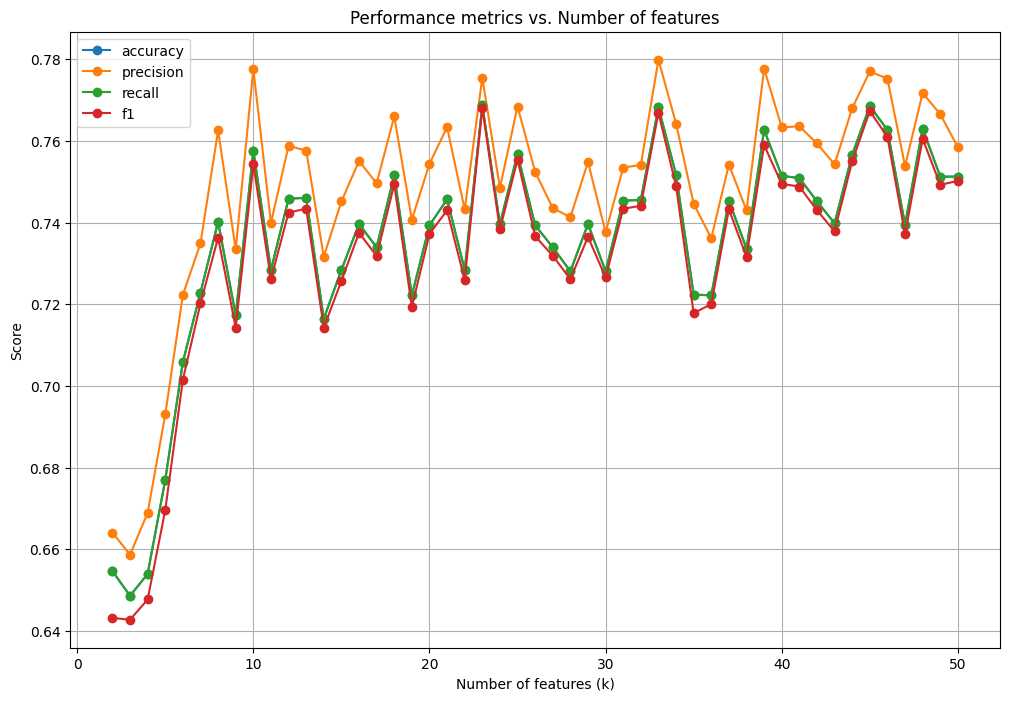

In [3]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Your existing NMIFS functions here (entropy, normalized_mutual_info, nmifs)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from ucimlrepo import fetch_ucirepo

def entropy(X):
    """Calculates the entropy of a feature"""
    _, counts = np.unique(X, return_counts=True)
    probabilities = counts / len(X)
    return -np.sum(probabilities * np.log2(probabilities + 1e-10))

def normalized_mutual_info(X, Y):
    """Calculates the normalized mutual information between X and Y"""
    mi = mutual_info_classif(X.reshape(-1, 1), Y, discrete_features=True)[0]
    return mi / min(entropy(X), entropy(Y))

def nmifs(X, y, k):
    """
    Feature selection with normalized mutual information
    
    X: feature matrix (n_samples, n_features)
    y: target variable
    k: number of features to select
    """
    n_features = X.shape[1]
    F = list(range(n_features))  # Initial set of features
    S = []  # Selected features
    
    # Compute MI with respect to the classes
    mi_y = [normalized_mutual_info(X[:, i], y) for i in range(n_features)]
    
    # Select the first feature
    best_feature = np.argmax(mi_y)
    S.append(best_feature)
    F.remove(best_feature)
    print(f'First feature selected: {best_feature}')
    
    # Greedy selection
    while len(S) < k:
        mi_scores = []
        for i in F:
            # Calculate the average normalized MI between the candidate feature and the selected features
            avg_mi = np.mean([normalized_mutual_info(X[:, i], X[:, j]) for j in S])
            
            # Calculate the selection criterion
            score = mi_y[i] - avg_mi
            mi_scores.append(score)
        
        # Select the feature that maximizes the score
        best_feature = F[np.argmax(mi_scores)]
        S.append(best_feature)
        F.remove(best_feature)
        print(f'New feature selected: {best_feature}')
    
    return S

class NMIFSSelector(BaseEstimator, TransformerMixin):
    def __init__(self, k):
        self.k = k
        
    def fit(self, X, y):
        self.selected_features_ = nmifs(X, y, self.k)
        return self
    
    def transform(self, X):
        return X[:, self.selected_features_]

# Load and preprocess the data
darwin = fetch_ucirepo(id=732) 
X = darwin.data.features 
y = darwin.data.targets 
X = X.drop(columns=['ID'])
y = np.ravel(y)

# Encode the target labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)


# Discretize continuous features
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample=200000)
X_discretized = discretizer.fit_transform(X)


# Define the Random Forest parameters
rf_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'random_state': 42
}

# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted'),
}

# Perform cross-validation for different k values
k_values = range(2, 51)
results = []

for k in k_values:
    pipeline = Pipeline([
        ('nmifs', NMIFSSelector(k)),
        ('rf', RandomForestClassifier(**rf_params))
    ])

    scores = cross_validate(pipeline, X_discretized, y_encoded, cv=5, scoring=scoring, n_jobs=-1)

    results.append({
        'k': k,
        'accuracy': scores['test_accuracy'].mean(),
        'precision': scores['test_precision'].mean(),
        'recall': scores['test_recall'].mean(),
        'f1': scores['test_f1'].mean()
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Print results
print(results_df)

# Visualize results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    plt.plot(results_df['k'], results_df[metric], marker='o', label=metric)

plt.xlabel('Number of features (k)')
plt.ylabel('Score')
plt.title('Performance metrics vs. Number of features')
plt.legend()
plt.grid(True)
plt.show()